<a href="https://colab.research.google.com/github/Beauremontt/Selected-SDSS-Spectrometry/blob/main/Selected_SDSS_Spectrometry.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# @title Modules and general functions

import numpy as np  # general maths
import matplotlib.pyplot as plt  # for plotting

import random

from astropy.io import fits  # for FITS handling

import os  # handling file directories
from google.colab import drive  # get drive as directory
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# @title Load spectral data

# file paths to data files
spectra_path = "/content/drive/MyDrive/SPS4020 Astrophysics 2/Project/Data/OLD_WRONG_SEARCH/spectra_FITS"
sPlines_path = "/content/drive/MyDrive/SPS4020 Astrophysics 2/Project/Data/SDSS_spectral_lines.csv"
SDSS_search_path = "/content/drive/MyDrive/SPS4020 Astrophysics 2/Project/Data/SDSS_search.csv"


# gets list of files in folder path; returns list of relative paths
def get_files(folder_path):

  os.chdir(folder_path)  # changes directory

  files = []
  for file_name in os.listdir():  # iterates over each file in directory
    if os.path.isfile(file_name):  # checks if it's a file and not a directory
      files.append(file_name)  # add file to array

  return files


## load spectra
# create list of relative paths to spectra
spectra_files = get_files(spectra_path)
spectra_files.sort()  # sort alphabetically

print(len(spectra_files), "spectra loaded as filepaths")
print(*spectra_files, "\n")


# create list of spectra fits files
spectra_fits = [fits.open(spectrum) for spectrum in spectra_files]

print(len(spectra_fits), "spectra fits files loaded as HDU lists")


## spectral line features mentioned by the SDSS
  # actual lines from SDSS, also get redshift? https://classic.sdss.org/dr3/dm/flatFiles/spSpec.php
  # basic line table mentioned in manual, https://classic.sdss.org/dr6/algorithms/linestable.php
# get array of [wavelengths, galaxy weight, quasar weight, 'species'] for the emission/absorption lines
lines = np.genfromtxt(sPlines_path, delimiter=',', dtype=(float, float, float, 'U12'), names=True)
    # columns keys are: ['wavelength', 'galaxy_weight', 'quasar_weight', 'species']

# split lines by weight
emissions = lines[:36]
absorptions = lines[37:]

# get indices of lines for ...
# ... galaxy_weight emissions
gw_em_idx = [i for i,gw in enumerate(emissions['galaxy_weight']) if gw > 0]
# ... galaxy_weight absorptions
gw_ab_idx = range(len(absorptions))  # every saved line absorbs
# ... quasar_weight emissions (QSOs don't have absorption lines)
qw_em_idx = [i for i,qw in enumerate(emissions['quasar_weight']) if qw > 0]


## SDSS search query results
  # table of results to compare IDs from HDULs to get redshifts and object classifications
  # order of specObs is the same as the sorted spectra_fits
specObs = np.genfromtxt(SDSS_search_path, delimiter=',', names=True,
                        usecols=(0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12),
                        dtype=['U4', 'U5', 'U3', 'U19', 'U12', 'U12', float, float, float, 'U2', 'U6', 'U12'])
    # columns keys are: ['plate', 'mjd', 'fiberid', 'specobj_id', 'ra', 'dec', 'sn_median_r', 'z', 'zerr', 'zwarning', 'class', 'subclass']

# add redshift and class information from SDSS search query to the FITS headers
new_keys = ['ra', 'dec', 'z', 'class', 'subclass']
for spectrum, RA, DEC, Z, CLASS, SUBCLASS in zip(spectra_fits, *[specObs[key] for key in new_keys]):
  headers = spectrum[0].header  # references the headers of PrimaryHDU

  # create new dictionary entries in the header
  headers['Z'] = Z  # redshift
  headers['CLASS'] = CLASS  # object class (star, galaxy, qso)
  headers['SUBCLASS'] = SUBCLASS  # '' (starforming, starburst, broadline)

  # edit coordinate entries from degrees to hours:minutes:seconds
  headers['RA'] = RA  # right-ascension coordinate of target
  headers['DEC'] = DEC  # declination coordinate

31 spectra loaded as filepaths
spec-0519-52283-0021.fits spec-0519-52283-0023.fits spec-0519-52283-0028.fits spec-0519-52283-0029.fits spec-0519-52283-0030.fits spec-0519-52283-0039.fits spec-0520-52288-0264.fits spec-0520-52288-0265.fits spec-0520-52288-0269.fits spec-0520-52288-0270.fits spec-0520-52288-0274.fits spec-0520-52288-0276.fits spec-0520-52288-0278.fits spec-0520-52288-0279.fits spec-0520-52288-0280.fits spec-4752-55653-0209.fits spec-4752-55653-0210.fits spec-4752-55653-0211.fits spec-4752-55653-0212.fits spec-4752-55653-0213.fits spec-4752-55653-0215.fits spec-4752-55653-0217.fits spec-4752-55653-0218.fits spec-4752-55653-0219.fits spec-4752-55653-0262.fits spec-4752-55653-0264.fits spec-4752-55653-0268.fits spec-4752-55653-0272.fits spec-4752-55653-0274.fits spec-4752-55653-0277.fits spec-4752-55653-0280.fits 

31 spectra fits files loaded as HDU lists


In [ ]:
# @title Analyze line broadening

# choose spectral feature
line_id = 0
line = lines[line_id]
print(line['species'], "line:", line['wavelength'], "Å")

# choose target
spectrum_id = 0
spectrum = spectra_fits[spectrum_id]
print("SDSS ID ")

O VI line: 1033.82 Å


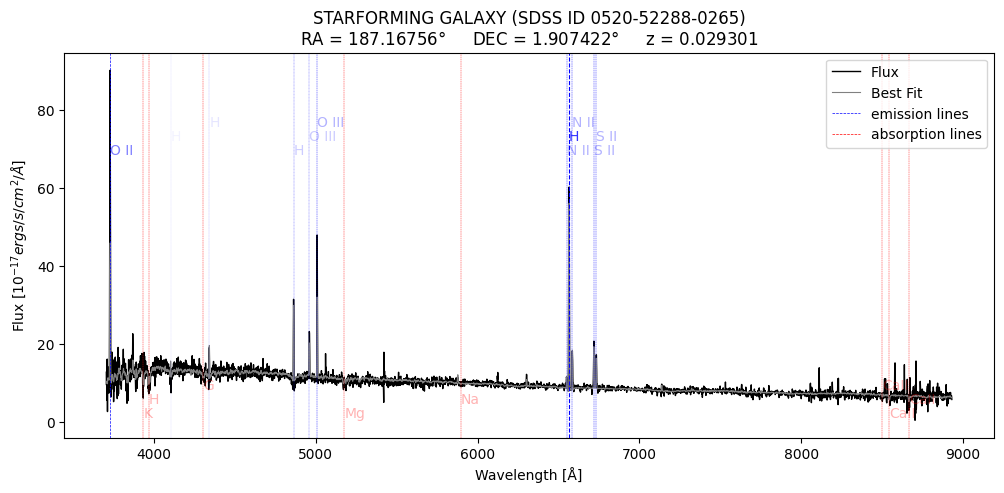

In [ ]:
# @title Plot selected spectrum  { form-width: "1px" }
# you choose a single spectrum to plot
# for messing around with plot settings without waiting ~20 seconds

# index of spectrum in spectra_files list to use
choose_spectrum_id = 7 # @param {type:"slider", min:0, max:31, step:1}


# wrap spectrum plotting as a function; allows single or looping plots
# keep in mind that none of these variables are saved
def PLOT_SPECTRUM(spectrum_id):

  ## load data for chosen spectrum
  # get specified spectrum data
  target = spectra_files[choose_spectrum_id][5:-5]  # plate-mjd-fiberid of SDSS target
  spectrum = spectra_fits[choose_spectrum_id]  # HDUL
  COADD = spectrum[1]  # HDU 1 (extname COADD), "Coadded Spectrum from spPlate"

  # put relevant values into 1d arrays
  headers = spectrum[0].header
  wavelengths_obs = 10**COADD.data['loglam']
  targ_flux = COADD.data['flux']
  model_flux = COADD.data['model']


  ## comprehend data
  # redshift correction
  redshift = headers['Z']  # from SDSS database, not from earlier calculations
  wavelengths_src = wavelengths_obs / (1+redshift)

  # choose line set by the class of the target
  if headers['CLASS'] == "GALAXY":
    weight = 'galaxy_weight'
    emissions_targ = emissions[gw_em_idx]
    absorptions_targ = absorptions[gw_ab_idx]
  elif headers['CLASS'] == "QSO":
    weight = 'quasar_weight'
    emissions_targ = emissions[qw_em_idx]
    absorptions_targ = None
  else: # probably a star
    emissions_targ = None
    absorptions_targ = None



  ## plot spectrum of selected object
  plt.subplots(1, 1, sharex=True, figsize=(12,5))
  plt.title(f"{headers['SUBCLASS']} {headers['CLASS']} (SDSS ID {target})\nRA = {headers['RA']}$\degree$     DEC = {headers['DEC']}$\degree$     z = {redshift}")

  # draw spectrum's flux and best fit
  plt.plot(wavelengths_src, targ_flux, color='k', linewidth=1, label=f'Flux')
  plt.plot(wavelengths_src, model_flux, color='grey', linewidth=0.8, label='Best Fit')


  ## plot spectral line features
  # condition to filter for lines within plotted wavelength range
  def in_lam_range(line):
    val = line['wavelength']
    run = wavelengths_src
    if val > min(run) and val < max(run):
      return True
    else: return False

  # for offsetting the line labels
  top_plot = max(targ_flux)
  bot_plot = min(targ_flux)
  scale_plot = abs(top_plot-bot_plot)

  # mark emission lines
  if type(emissions_targ) != type(None):
    emissions_filt = filter(in_lam_range, emissions_targ)  # choose lines that fit on plot
    plt.plot([], color='blue', linestyle='--', linewidth=0.5, label='emission lines')  # add entry to legend
    for i, line in enumerate(emissions_filt):
      strength = 0.1*line[weight]  # how strongly the line should be annotated
      offset = bot_plot + scale_plot * (0.75 + 0.04*(i%3))  # cascade line markers vertically
      plt.axvline(x=line['wavelength'], color='blue', linestyle='--', linewidth=strength, label='_nolegend_')  # plot dashed line
      plt.text(line['wavelength'], offset, line['species'], color='blue', alpha=strength, verticalalignment='bottom')  # annotate line

  # mark absorption lines
  if type(absorptions_targ) != type(None):
    absorptions_filt = filter(in_lam_range, absorptions_targ)  # choose lines that fit on plot
    plt.plot([], color='red', linestyle='--', linewidth=0.5, label='absorption lines')  # add entry to legend
    for i, line in enumerate(absorptions_filt):
      strength = 0.3  # how strongly the line should be annotated (each absorption line has weight -1 for galaxies)
      offset = bot_plot + scale_plot * (0.0 + 0.04*(i%3))  # cascade line markers vertically
      plt.axvline(x=line['wavelength'], color='red', linestyle='--', linewidth=strength, label='_nolegend_')  # plot dashed line
      plt.text(line['wavelength'], offset, line['species'], color='red', alpha=strength, verticalalignment='bottom')  # annotate line


  ## plot configurations
  plt.xlabel("Wavelength [Å]")
  plt.ylabel("Flux [$10^{-17} ergs/s/cm^2/\AA$]")
  plt.legend()
  plt.show()


# perform for single plot
PLOT_SPECTRUM(choose_spectrum_id)

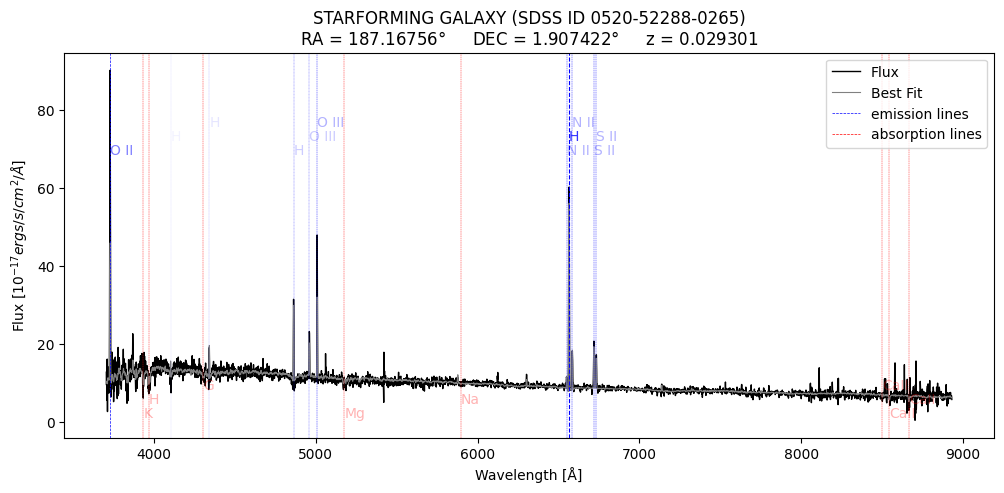

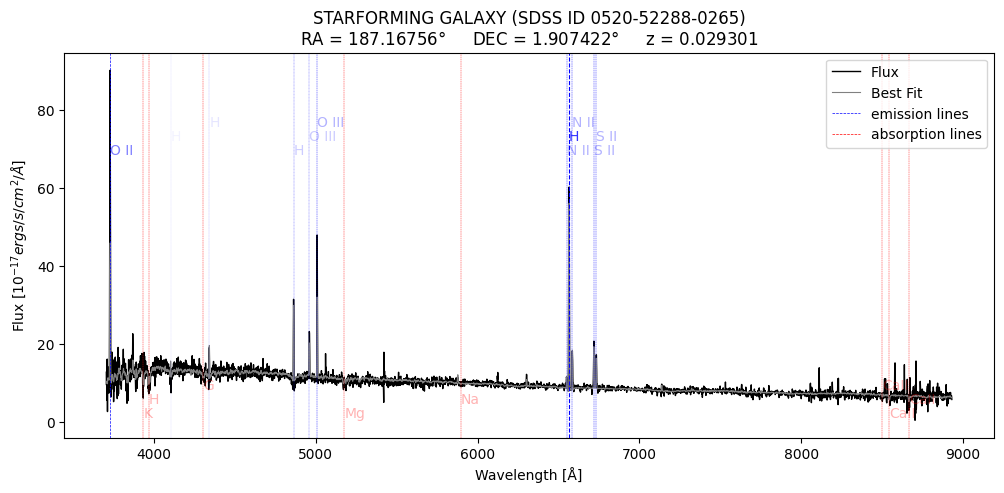

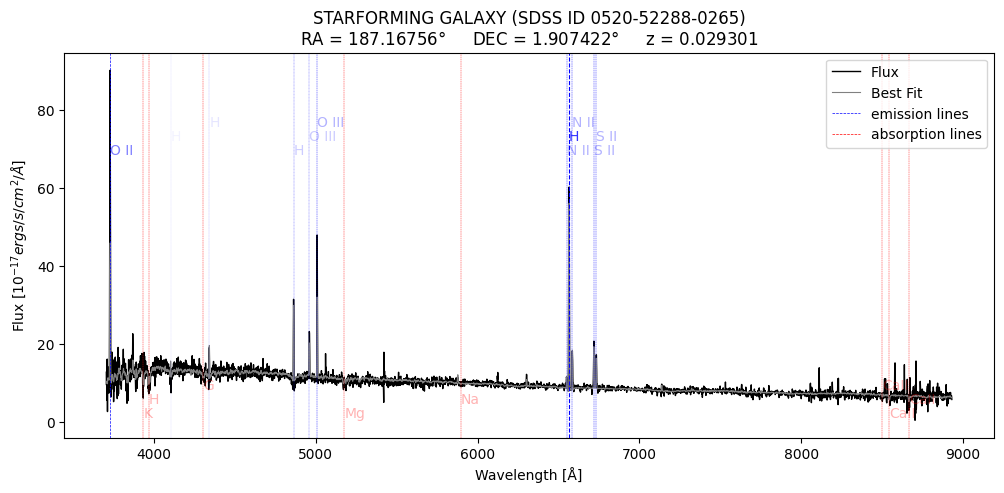

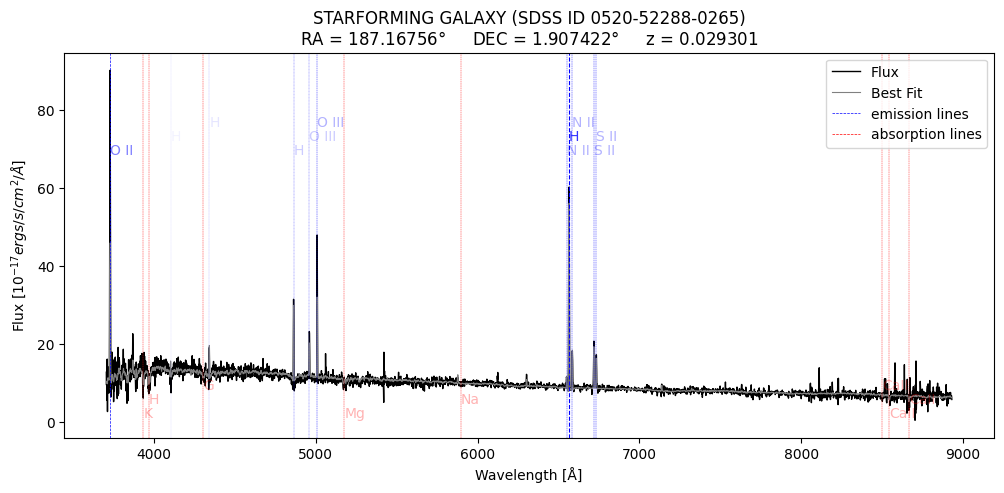

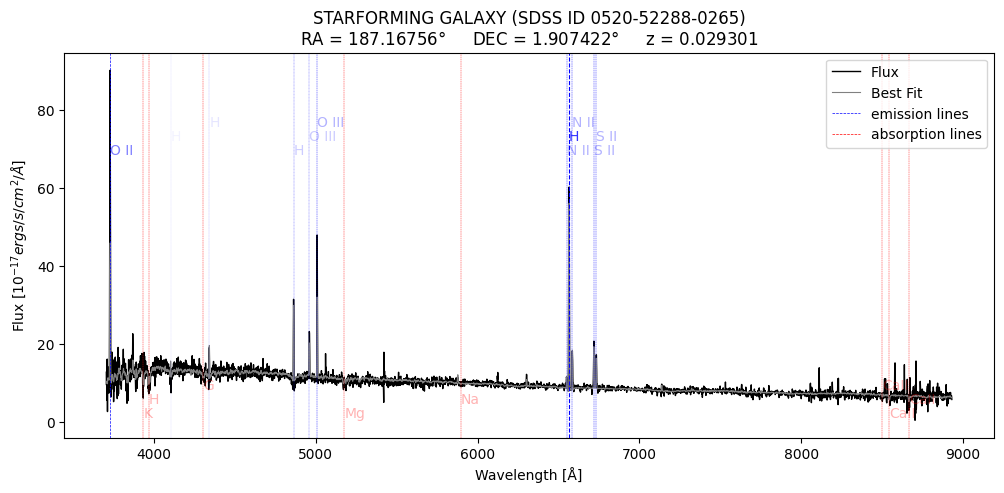

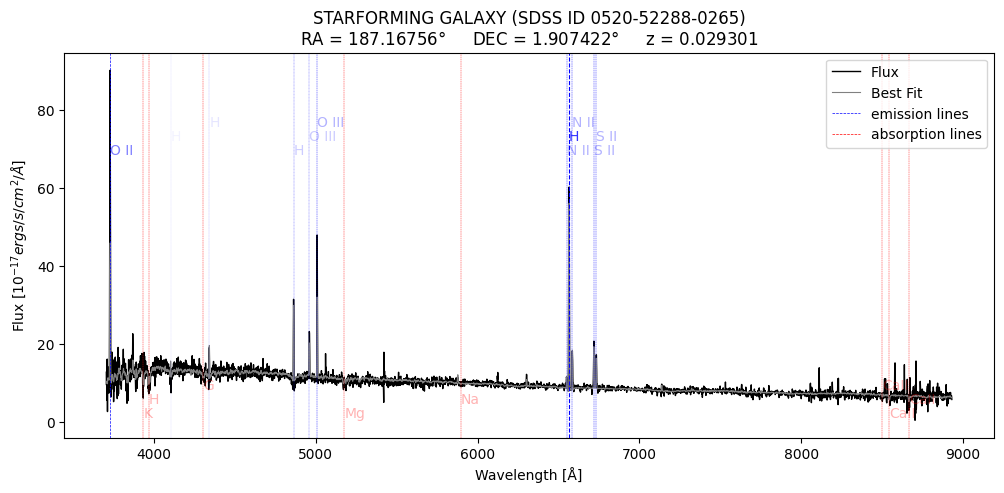

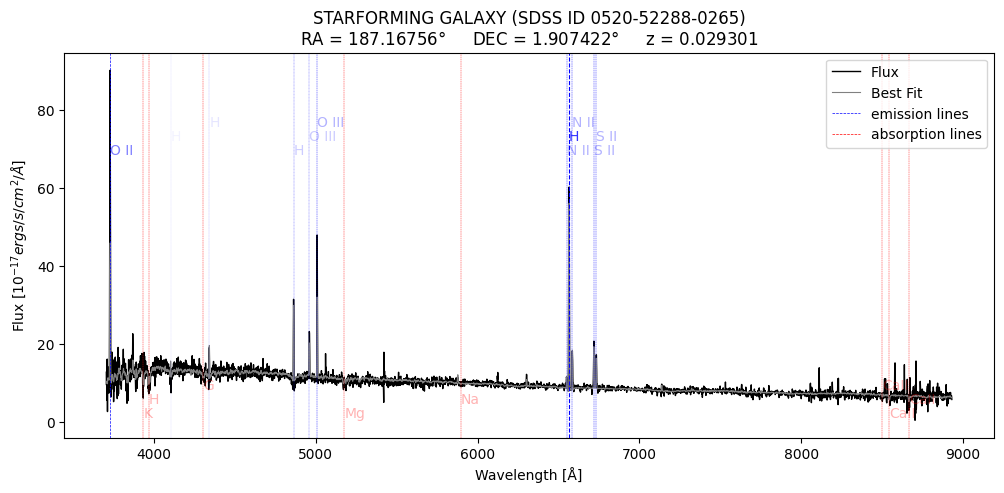

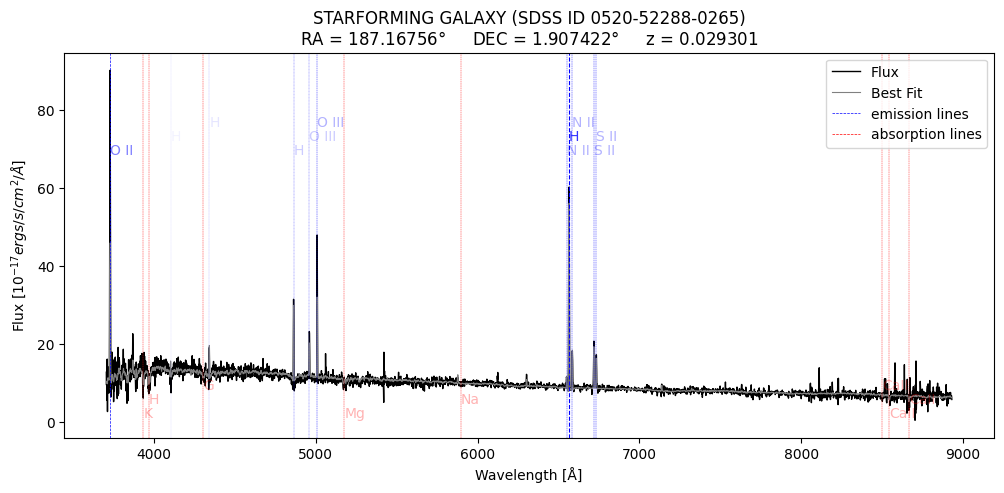

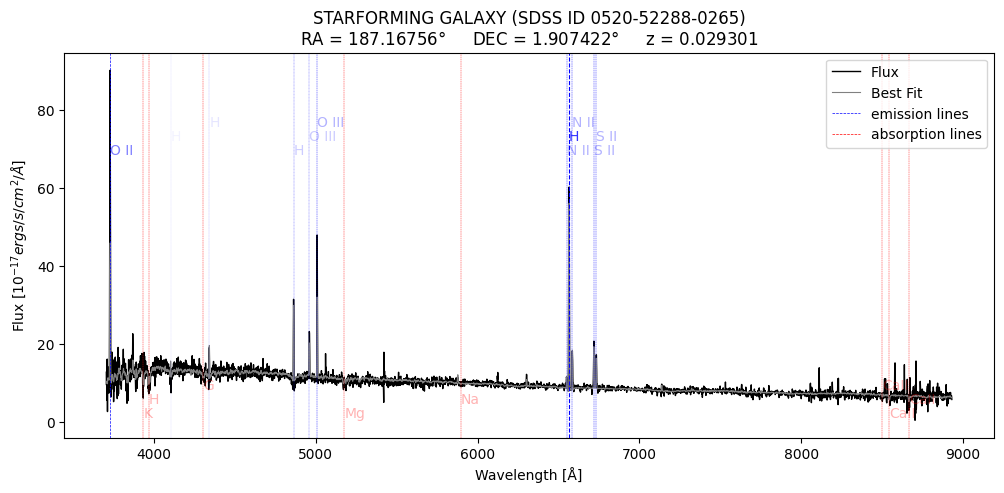

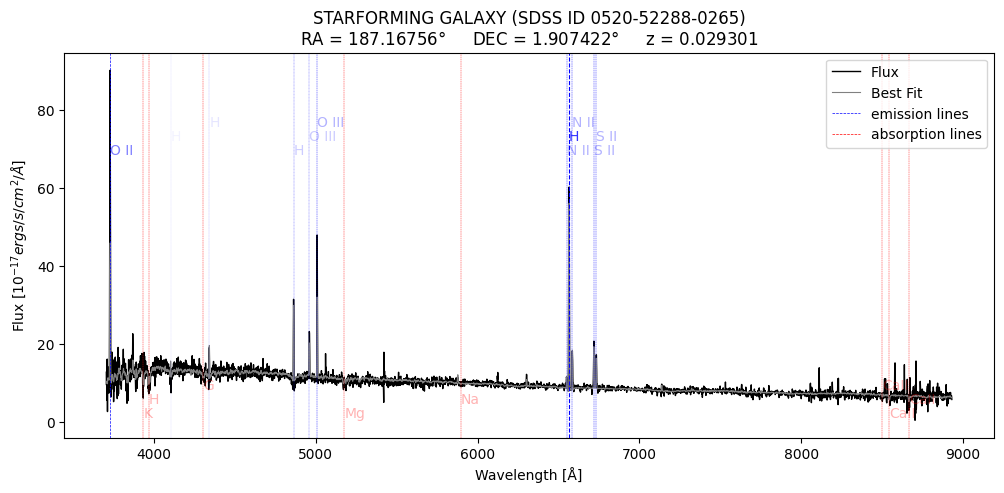

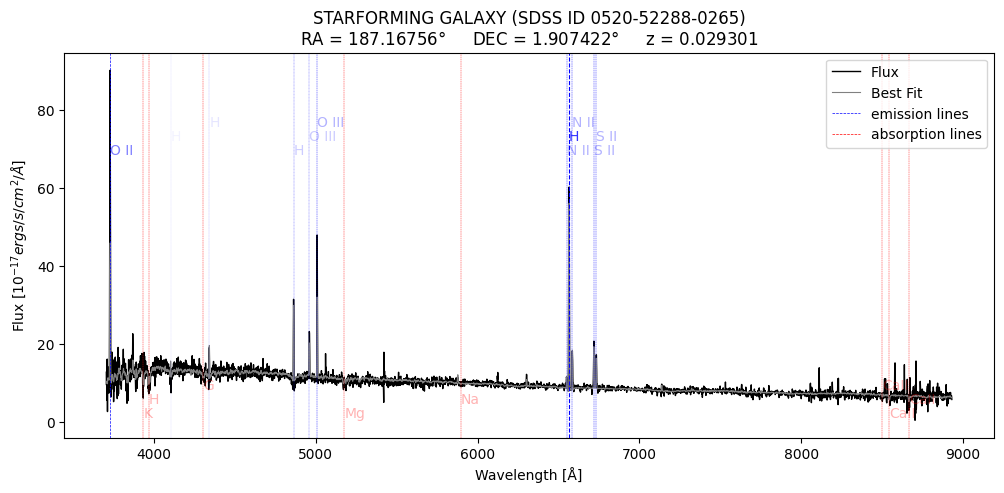

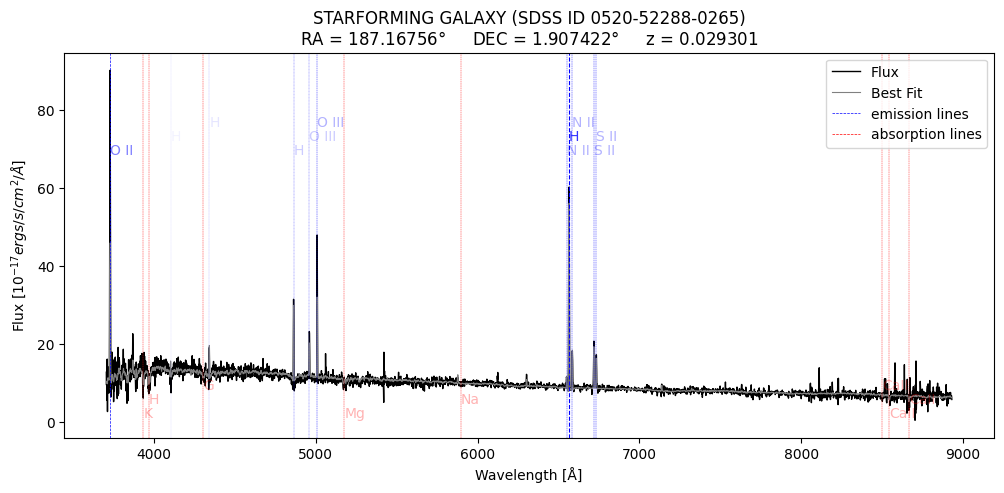

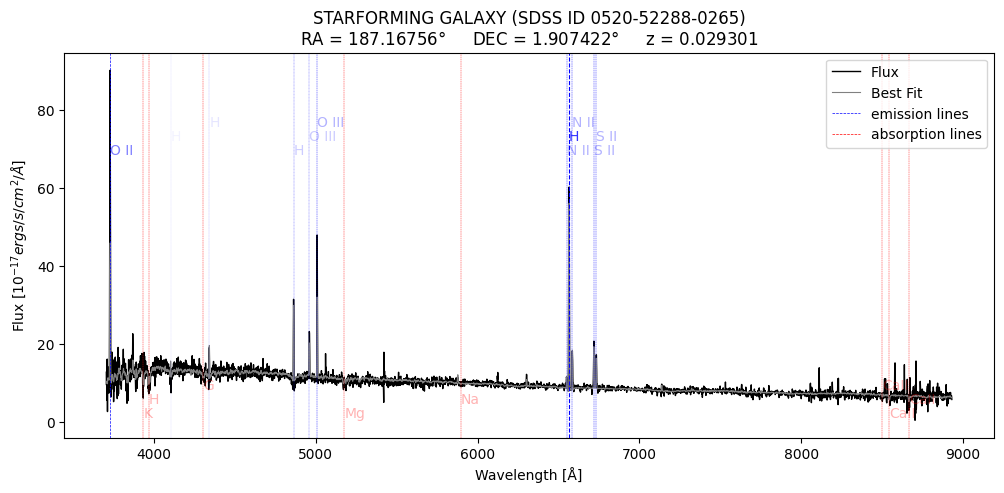

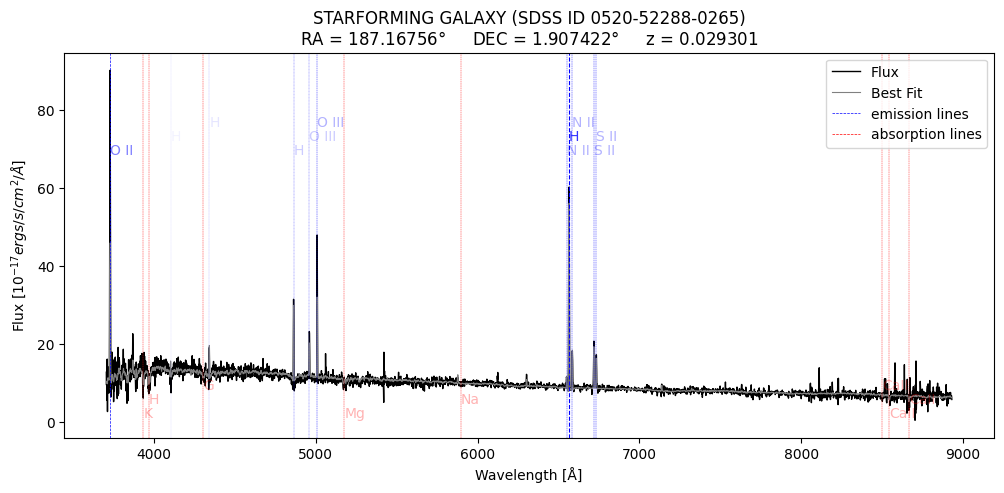

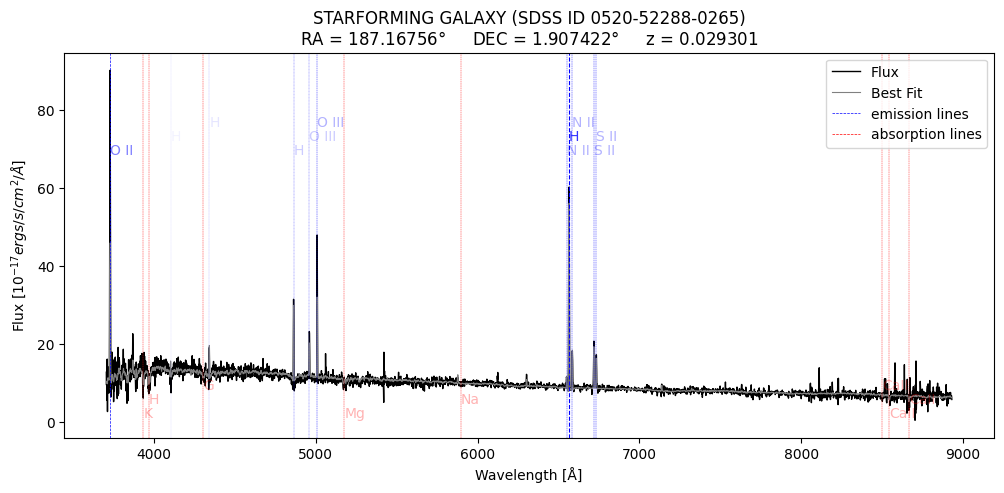

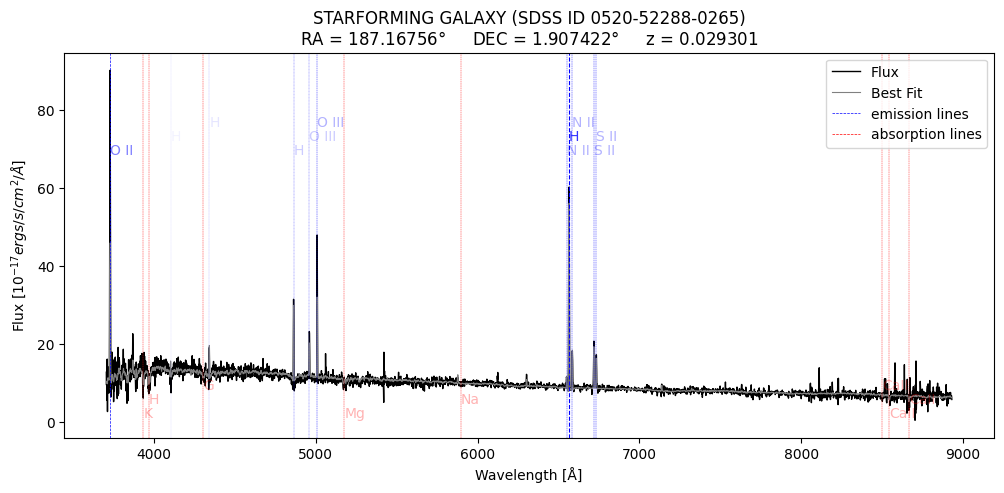

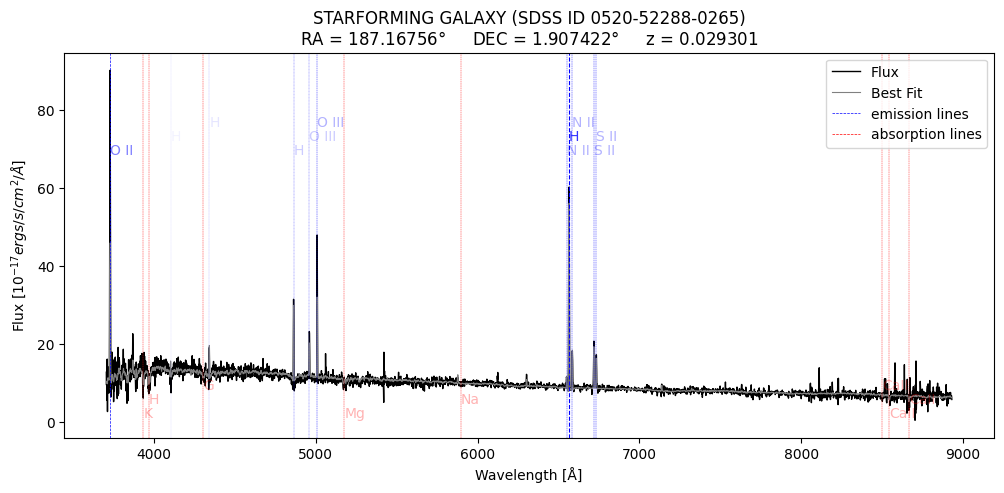

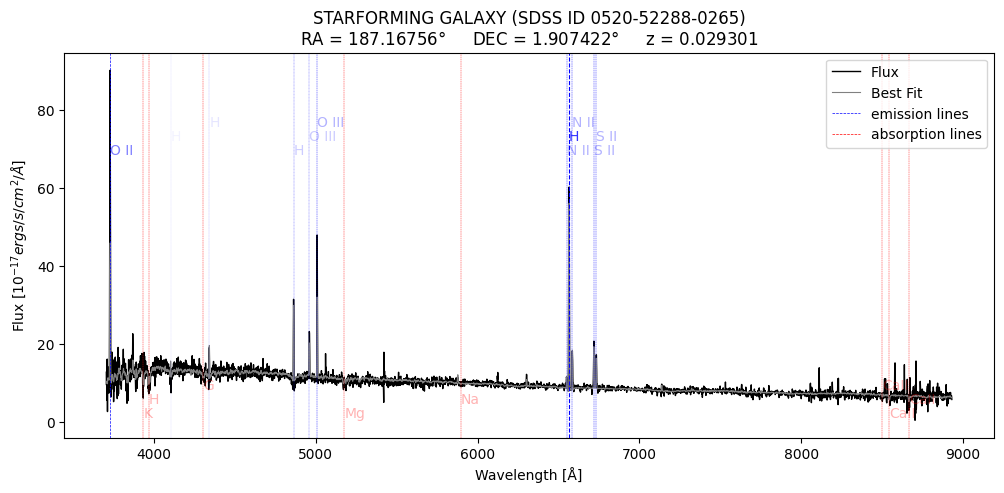

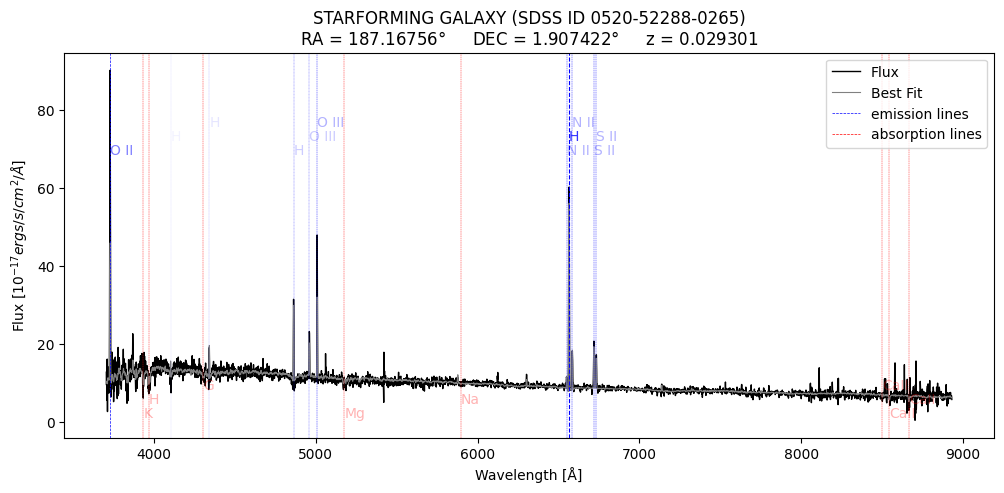

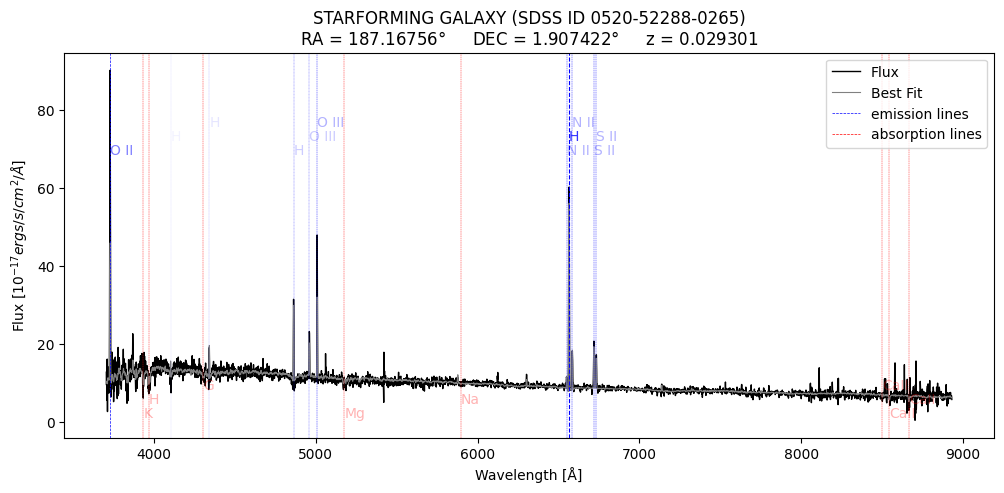

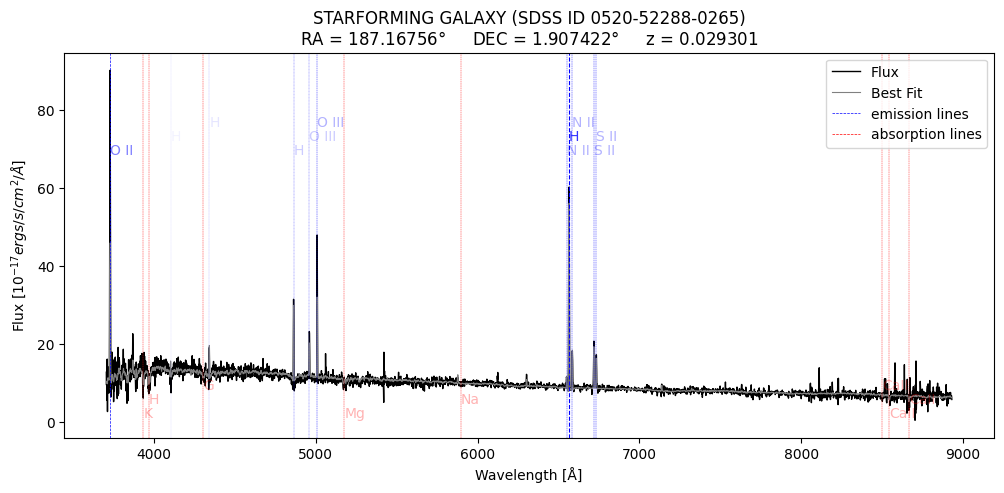

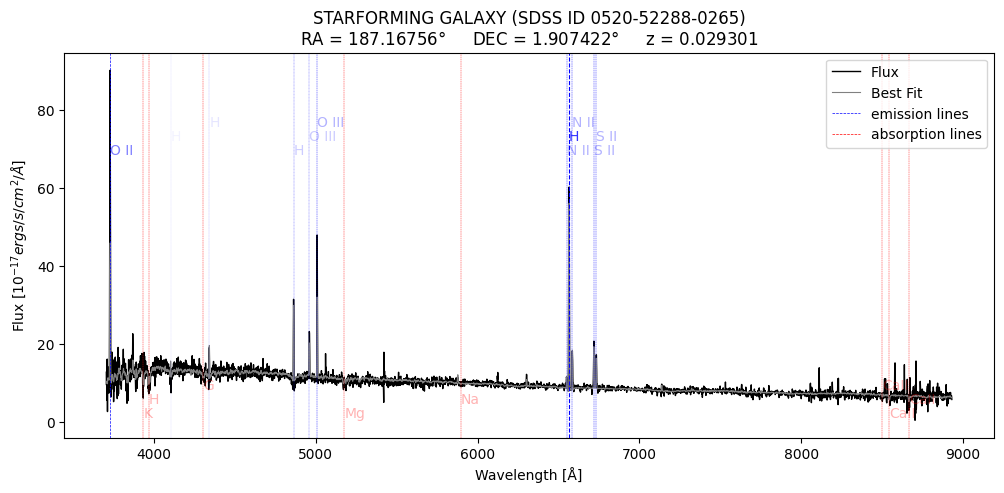

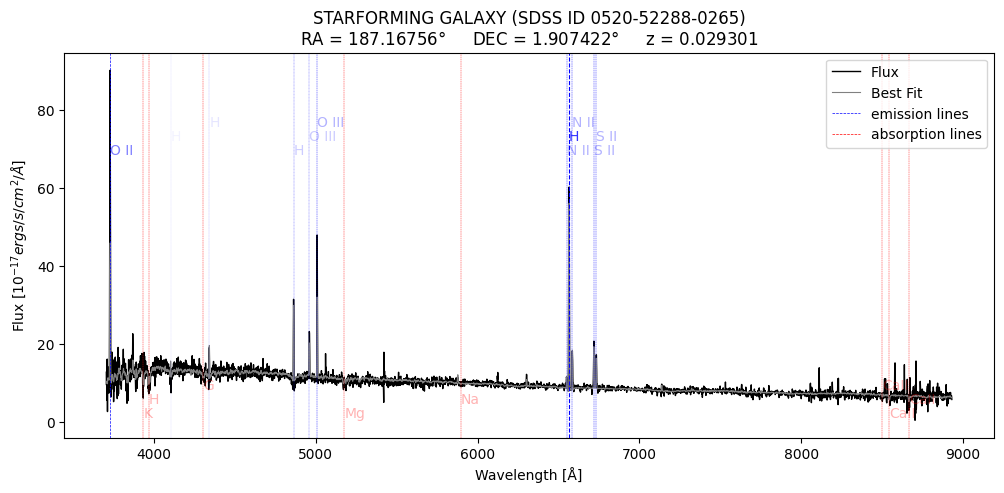

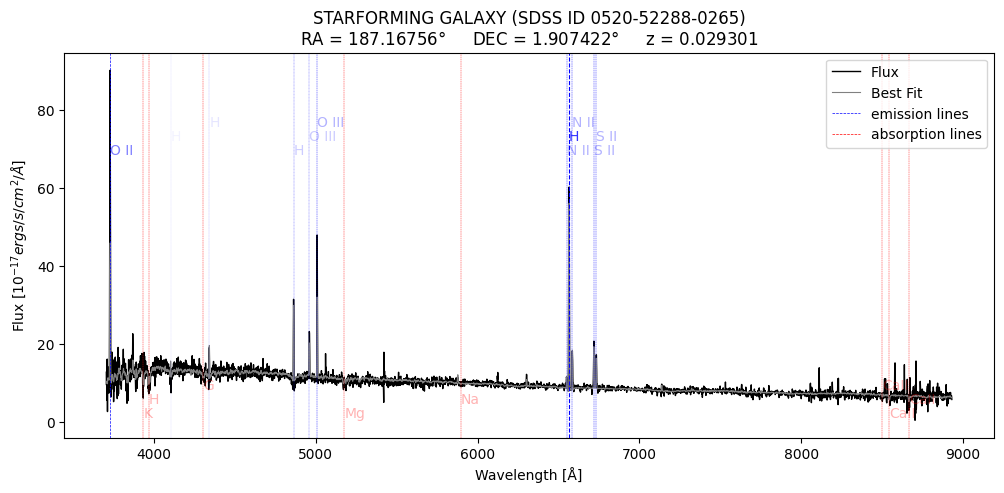

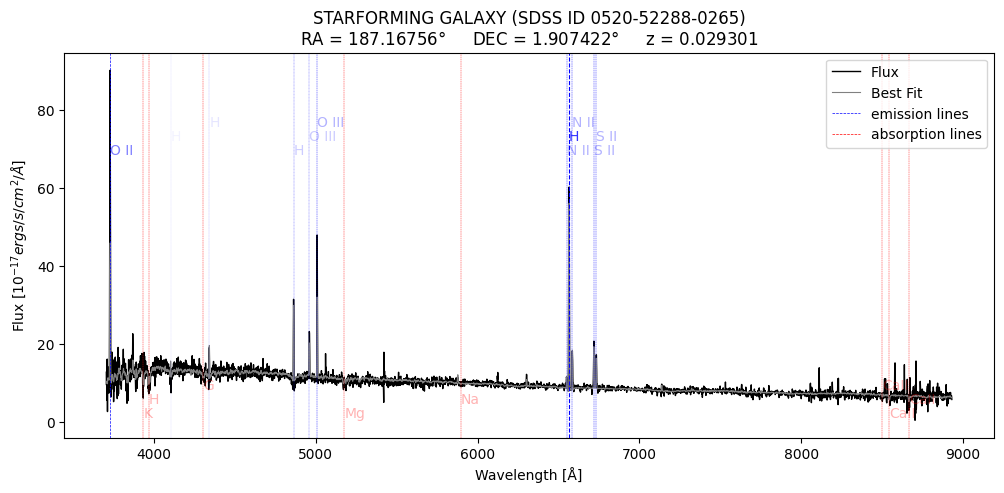

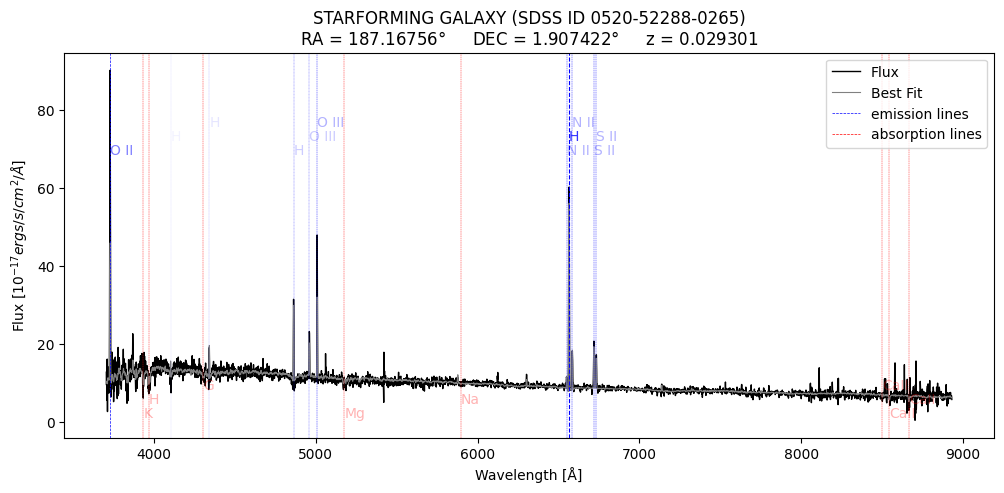

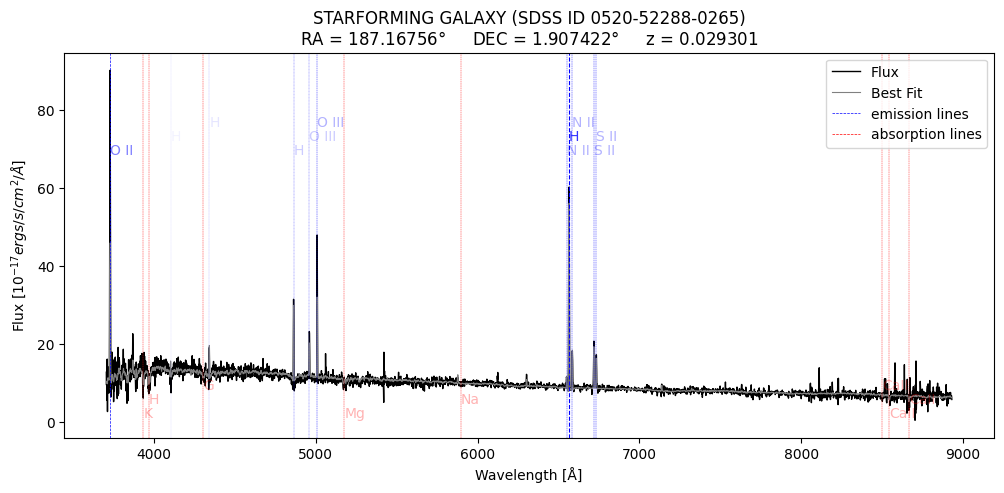

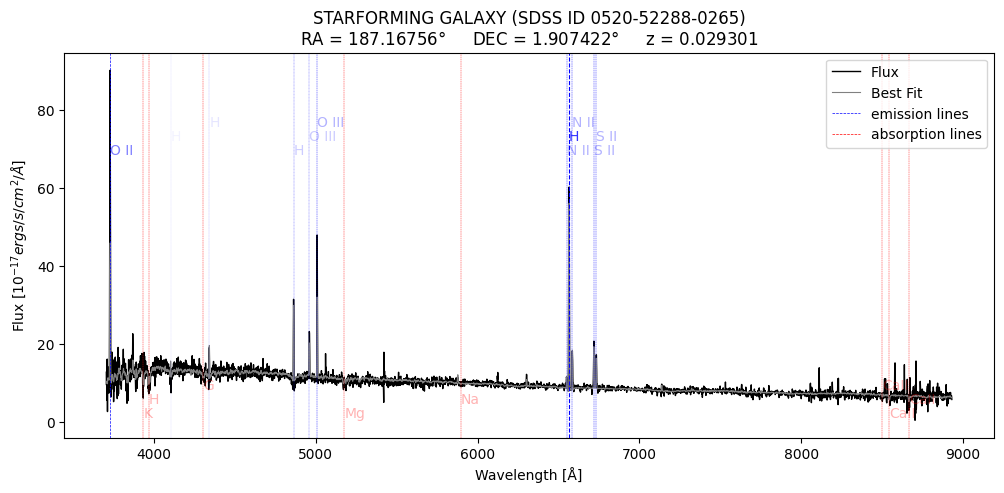

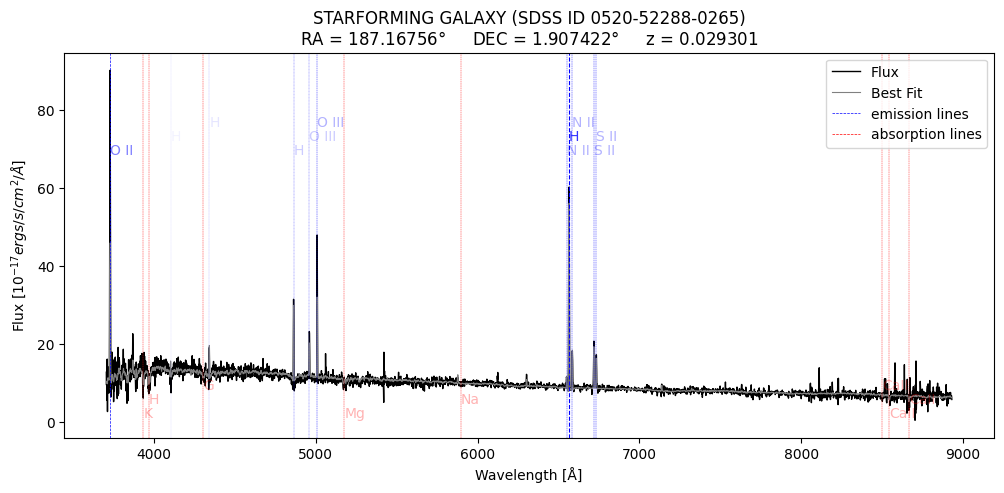

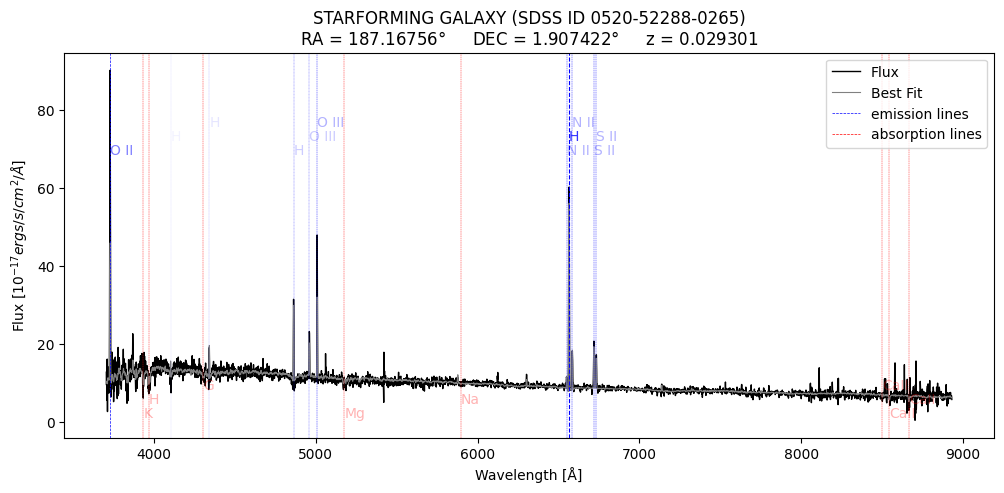

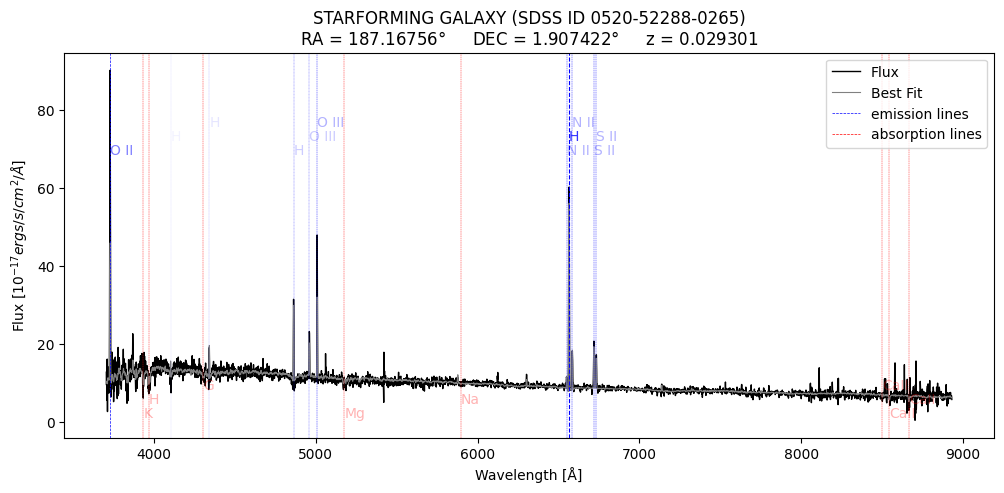

In [ ]:
# @title Plot every target spectrum

for spectrum_id in range(len(spectra_fits)):
  PLOT_SPECTRUM(spectrum_id)

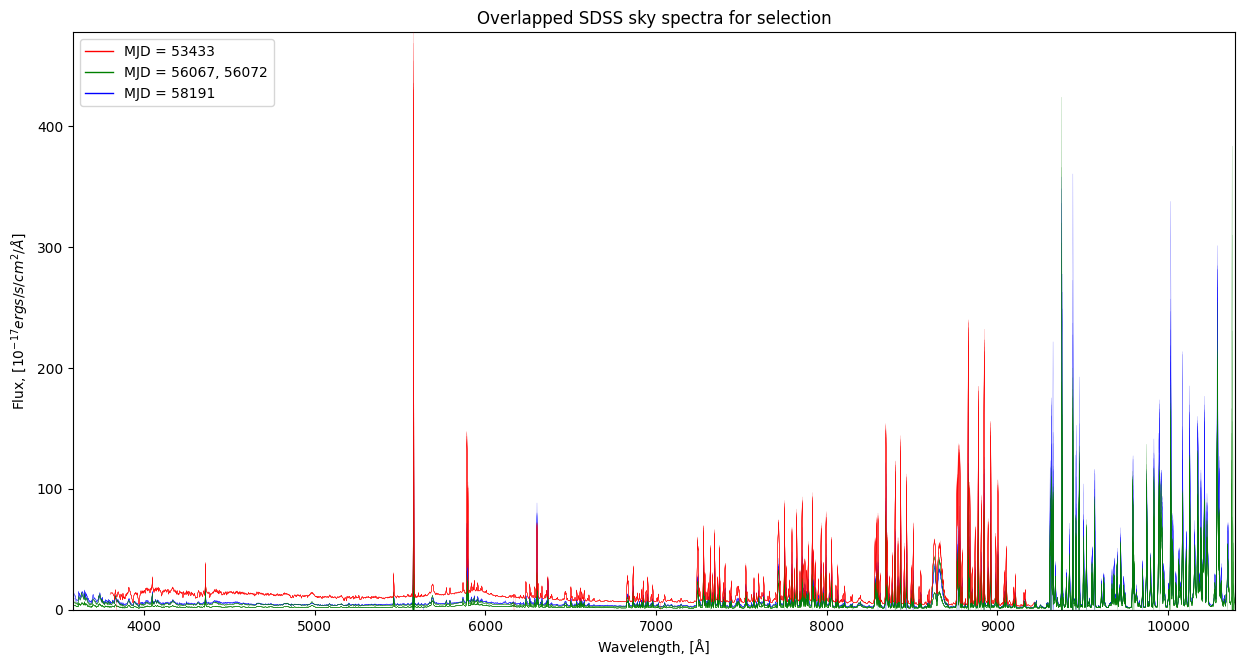

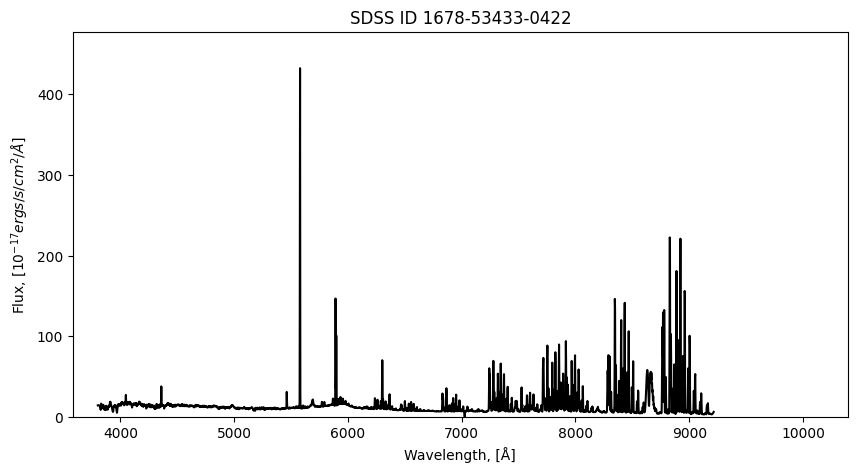

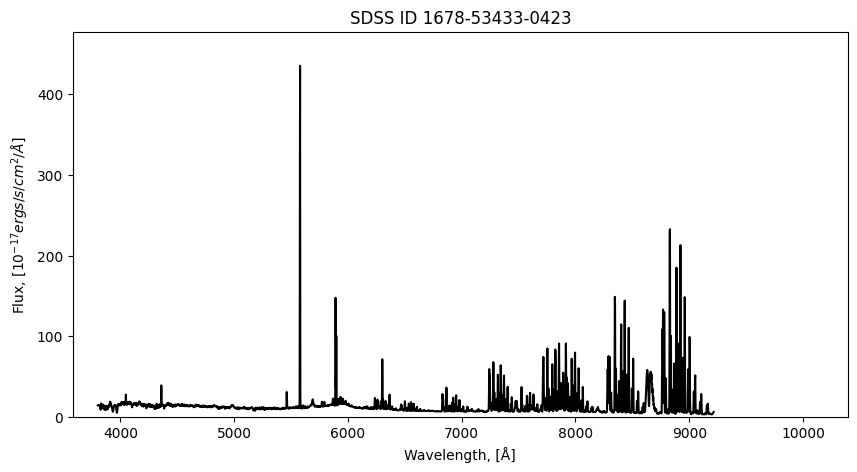

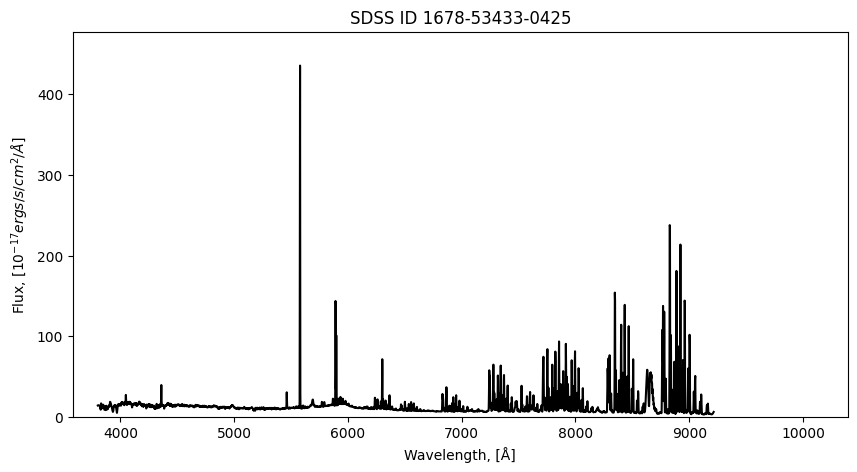

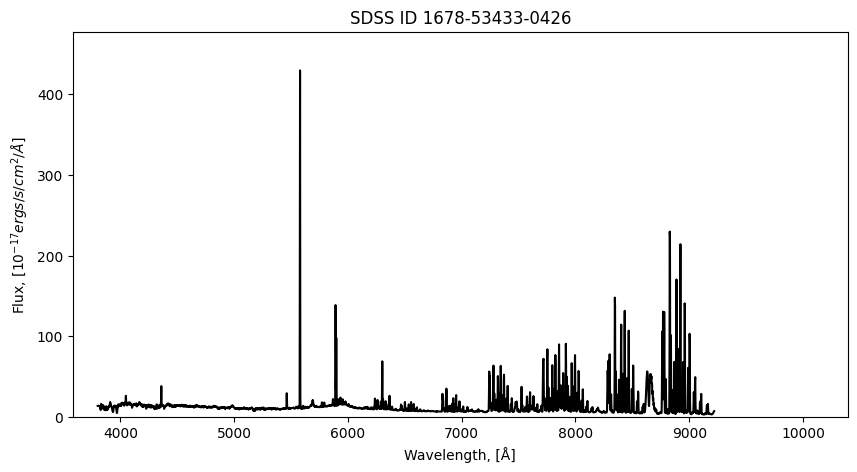

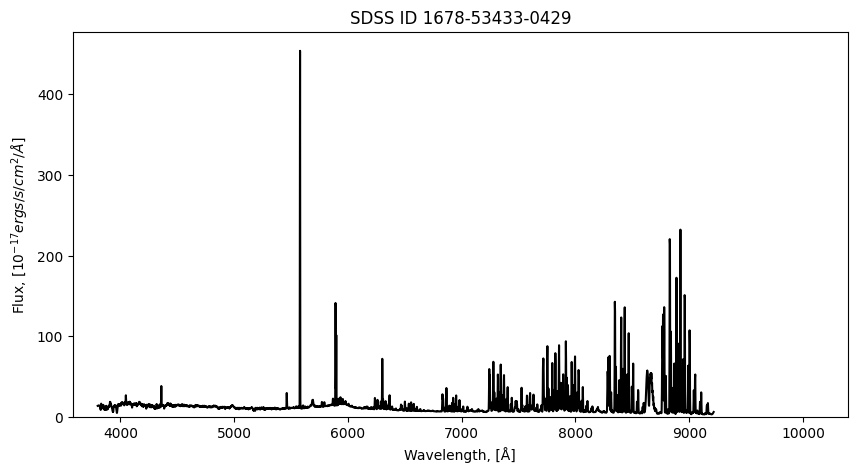

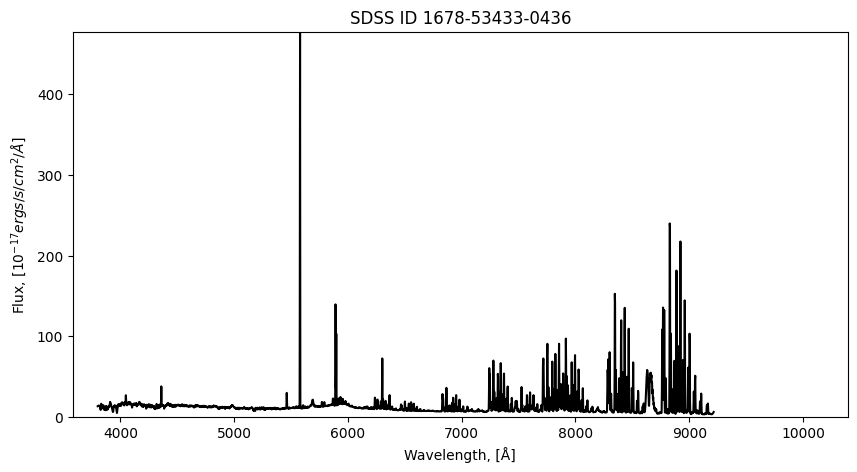

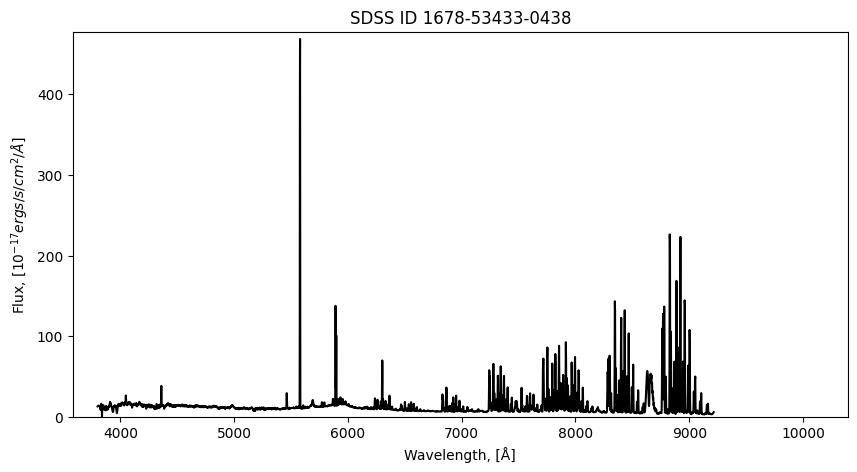

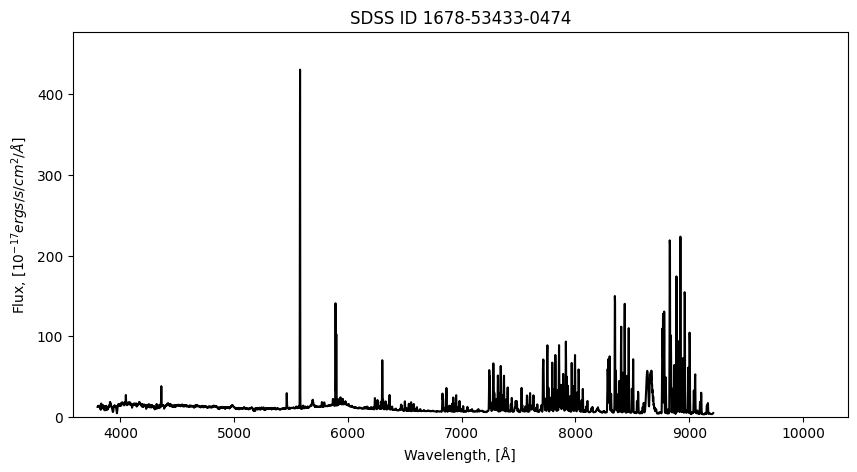

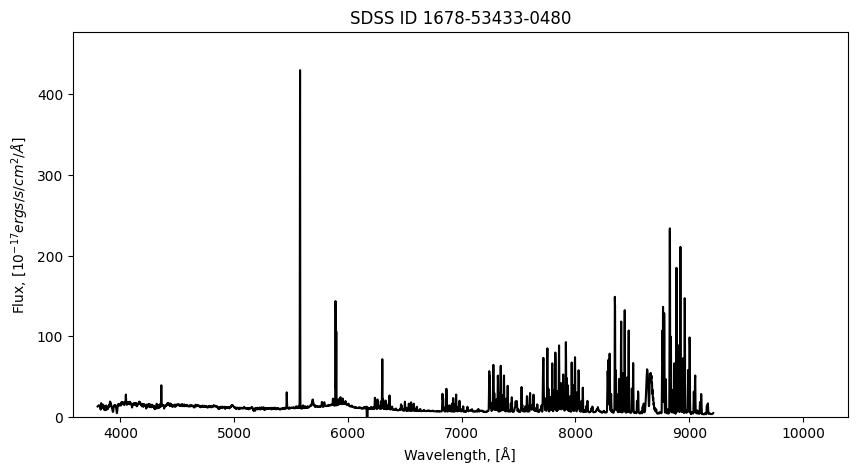

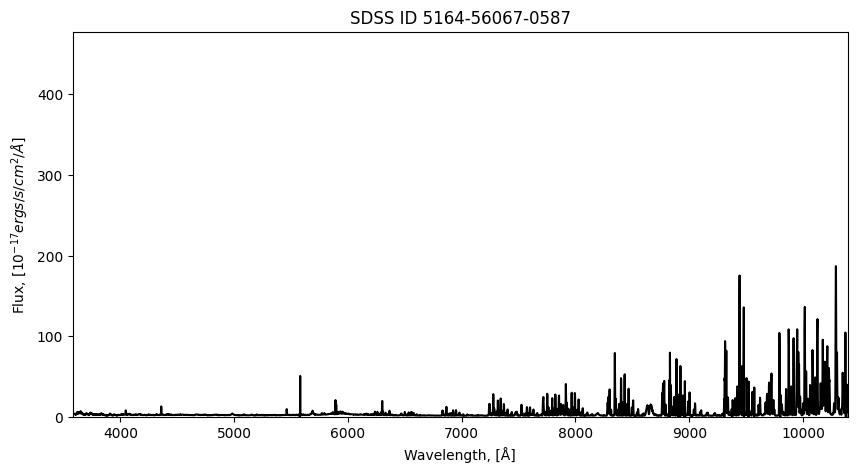

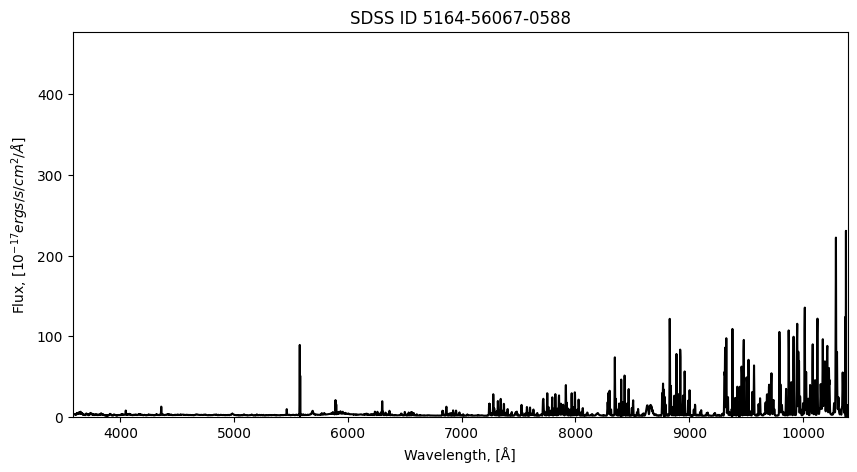

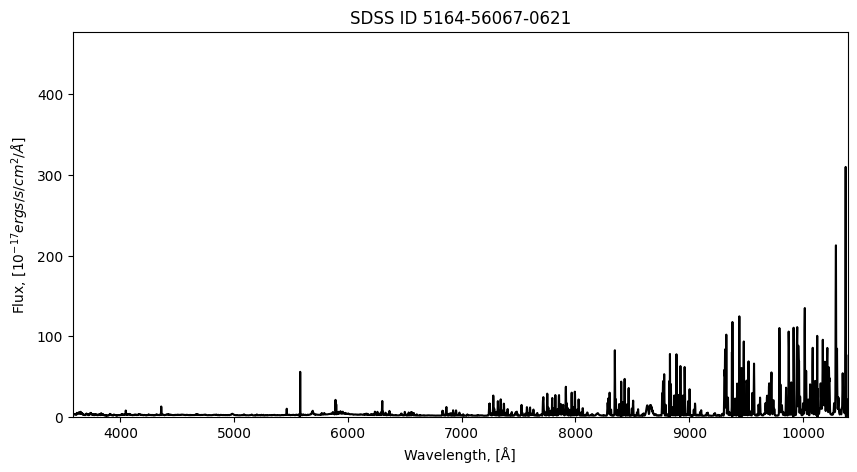

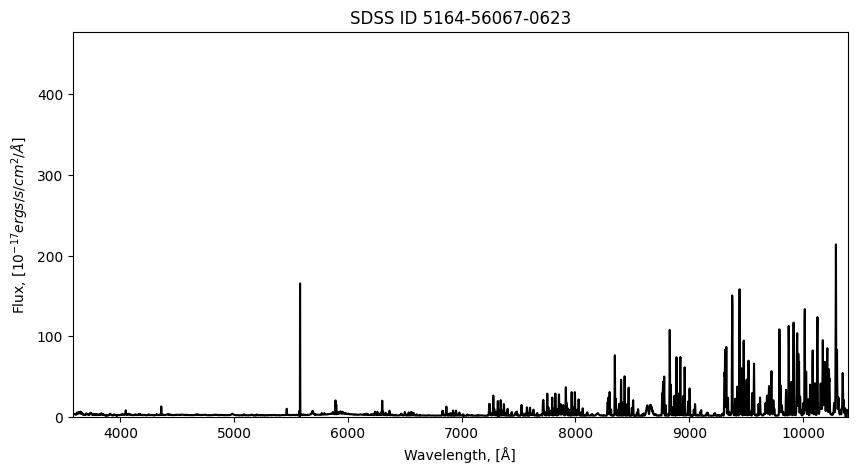

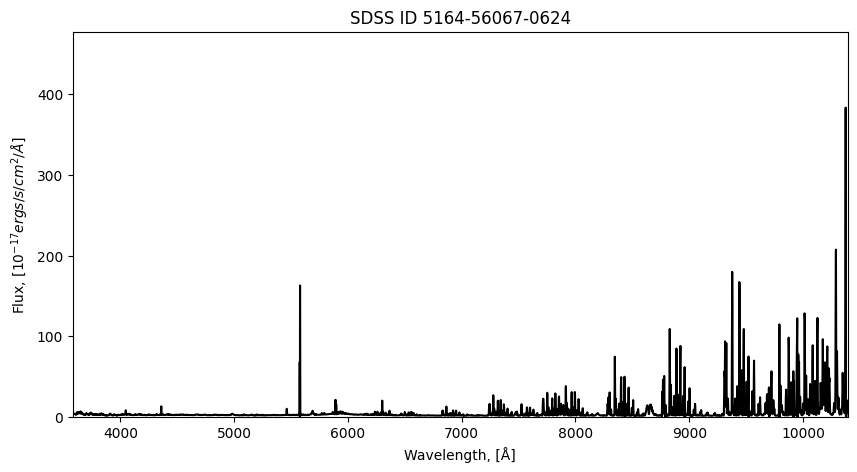

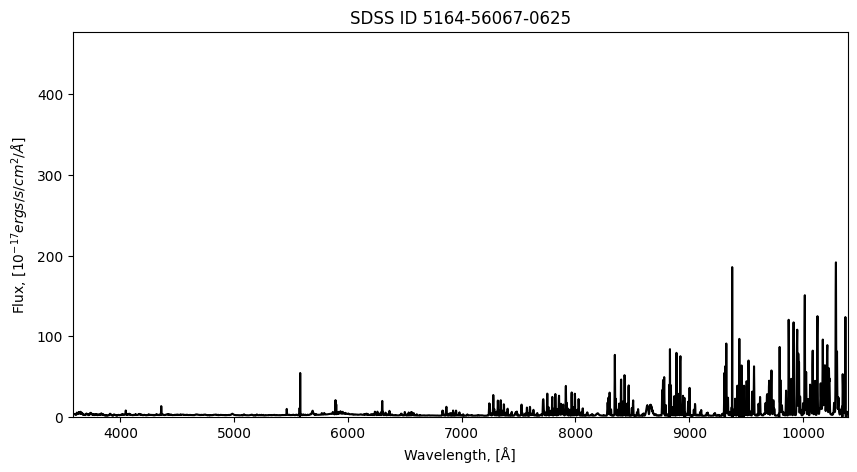

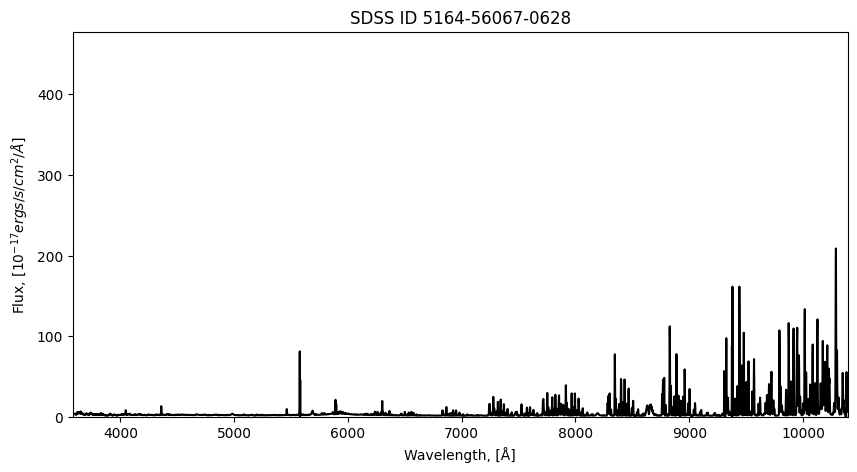

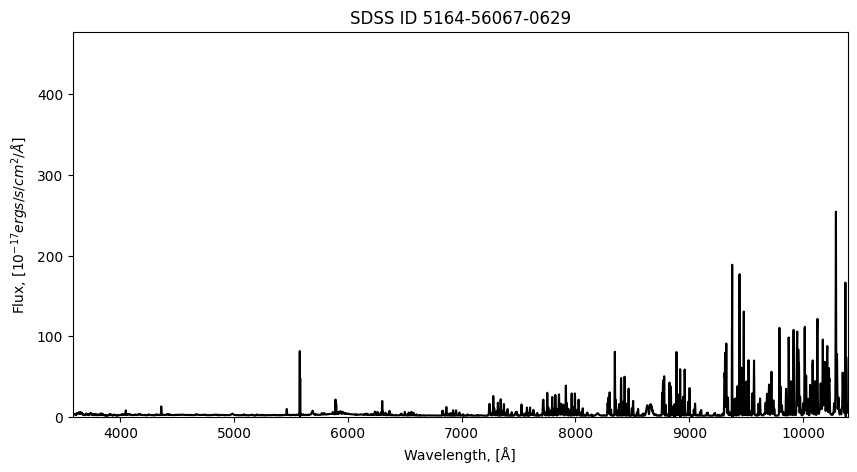

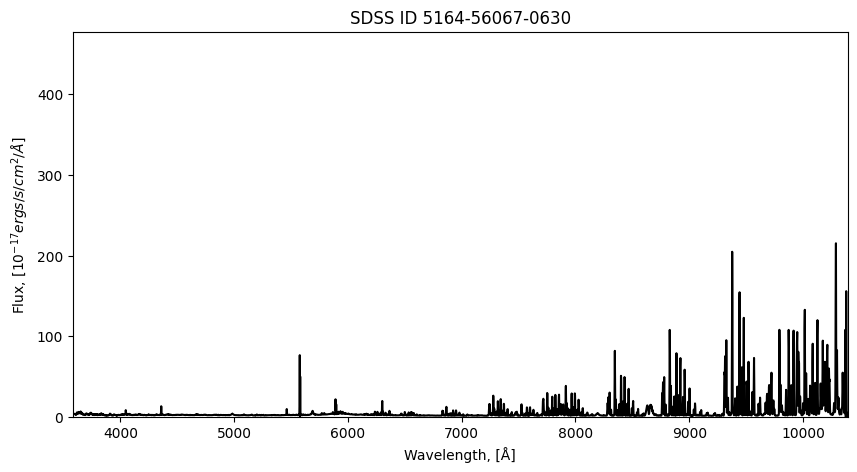

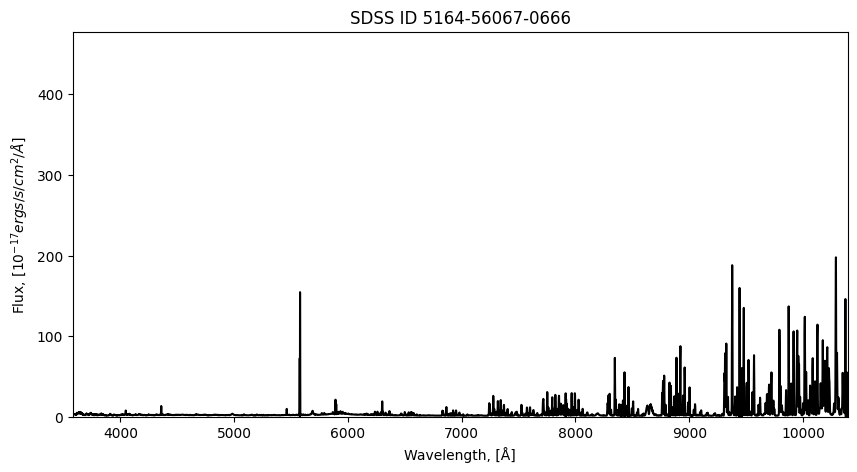

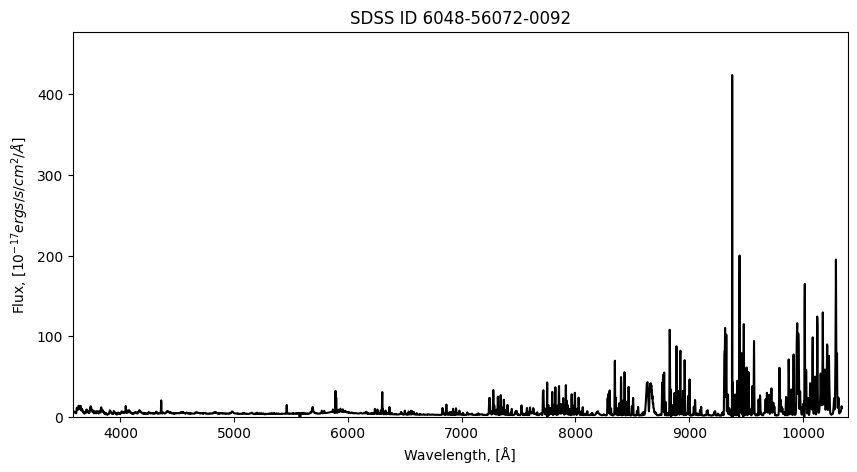

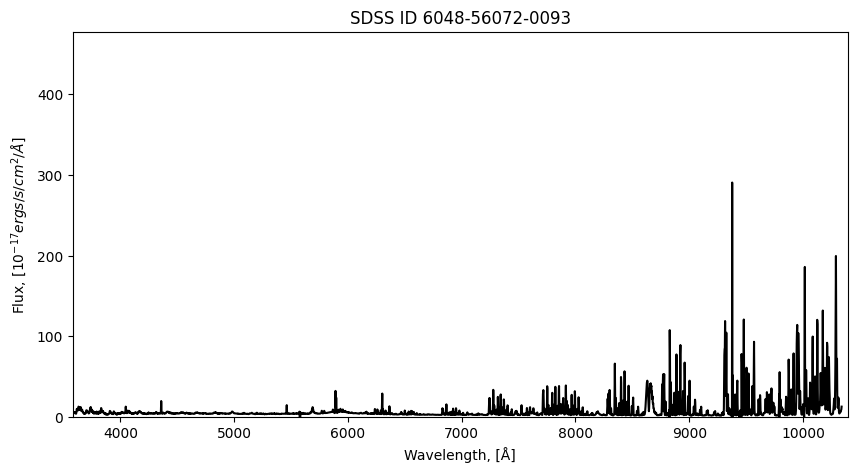

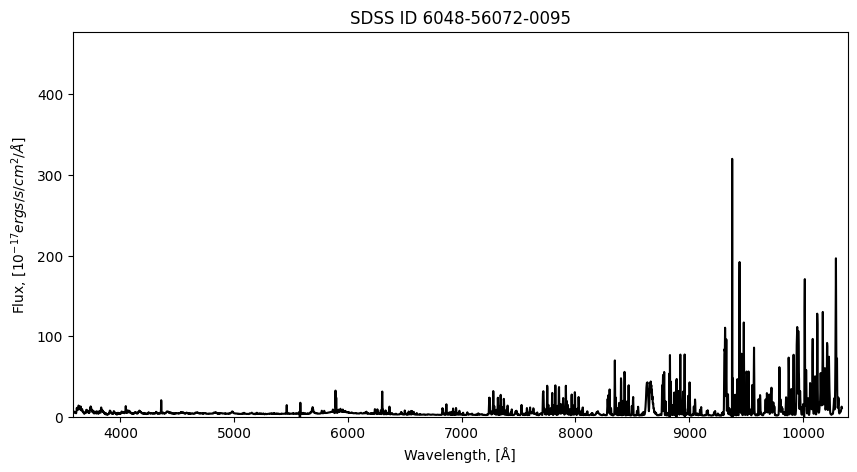

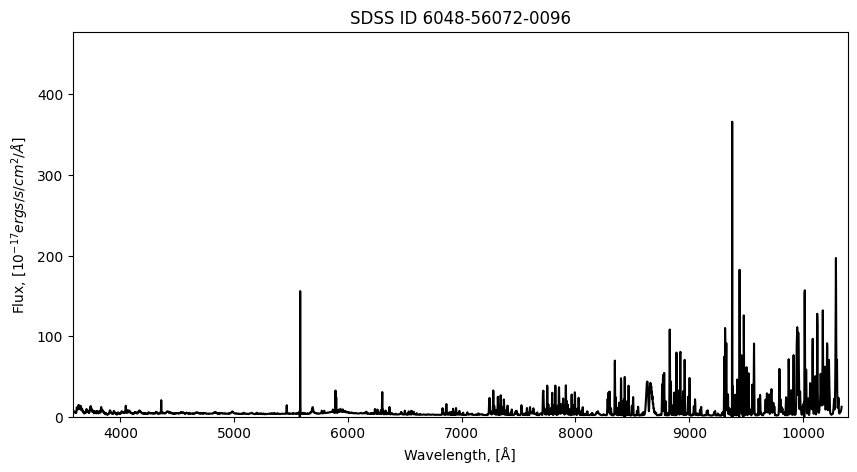

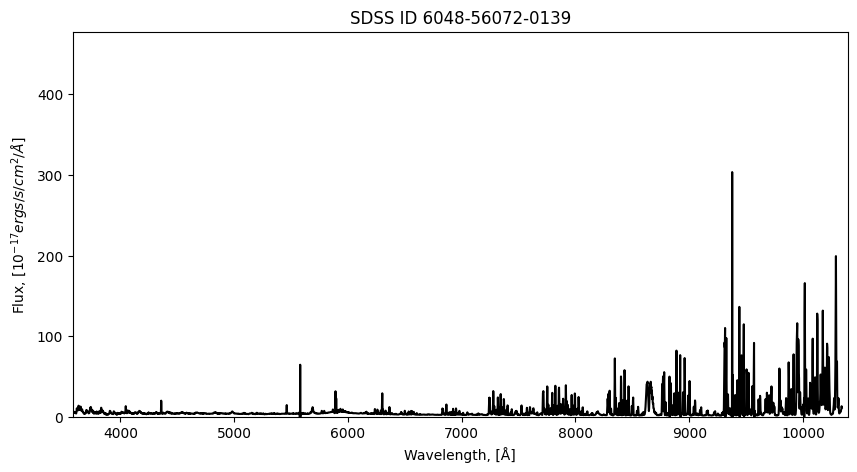

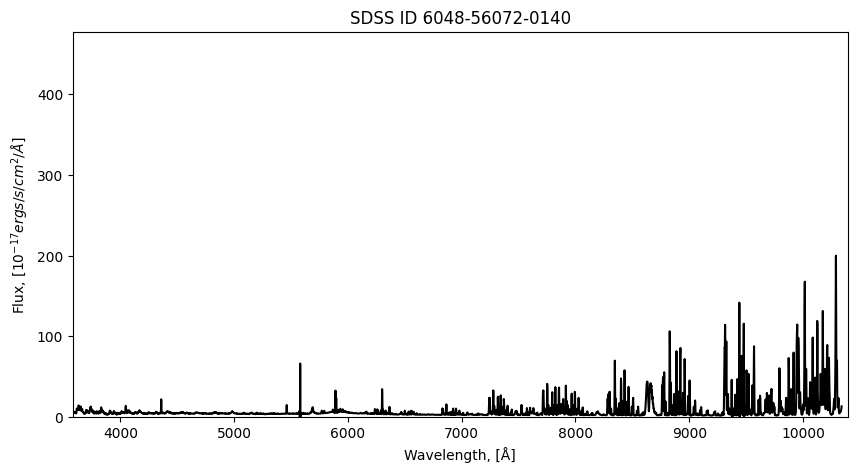

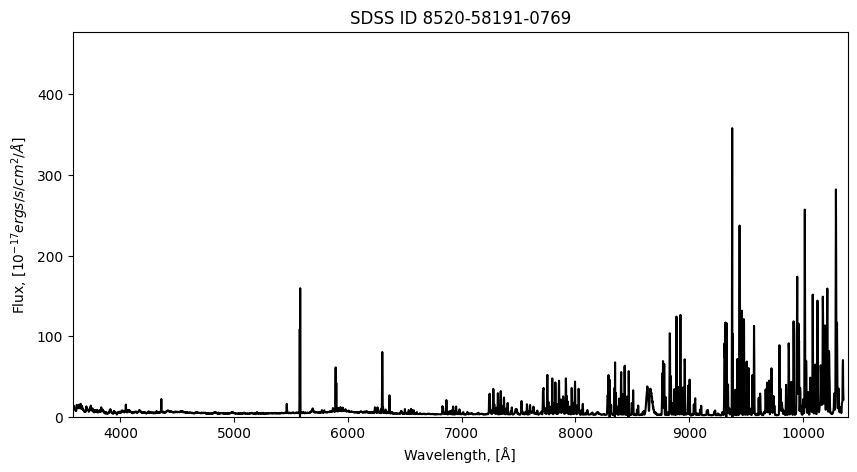

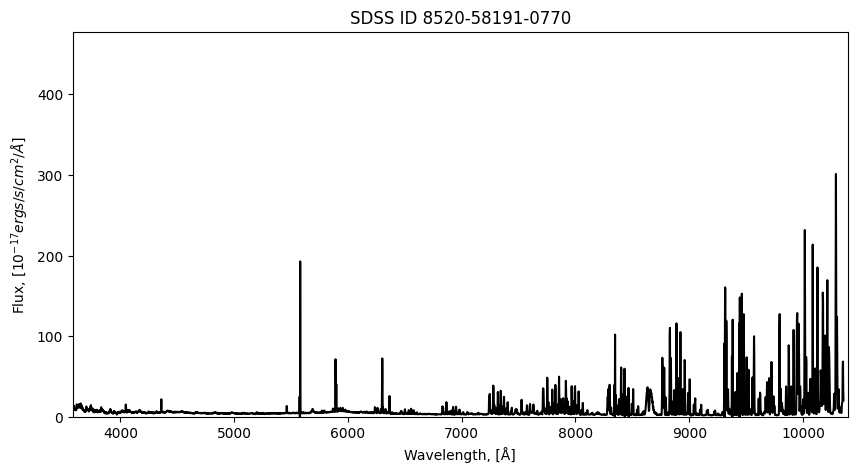

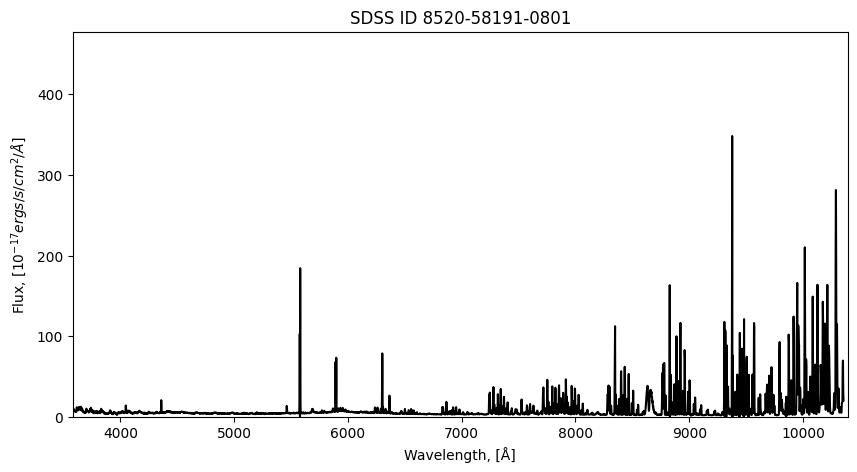

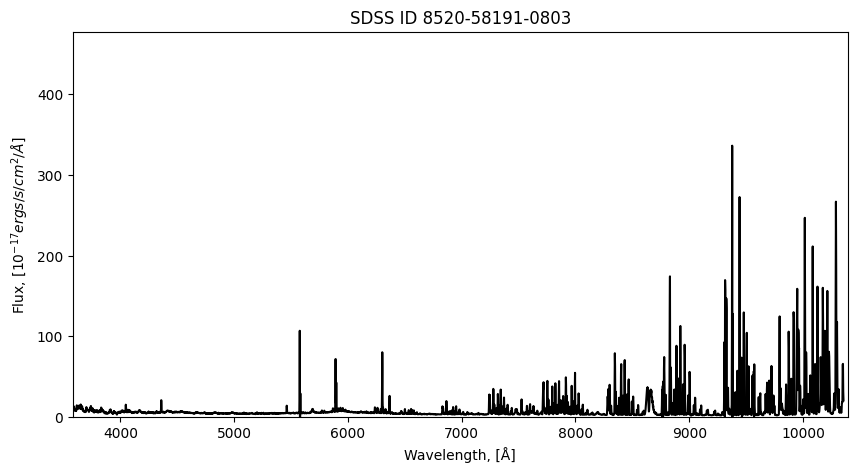

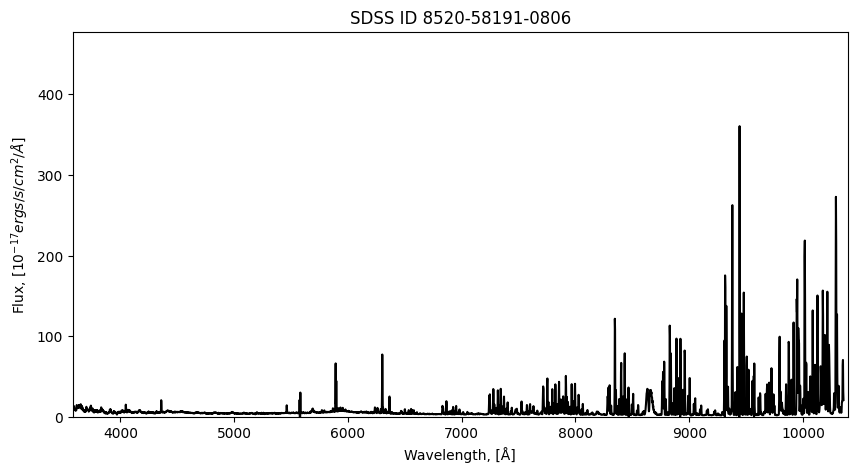

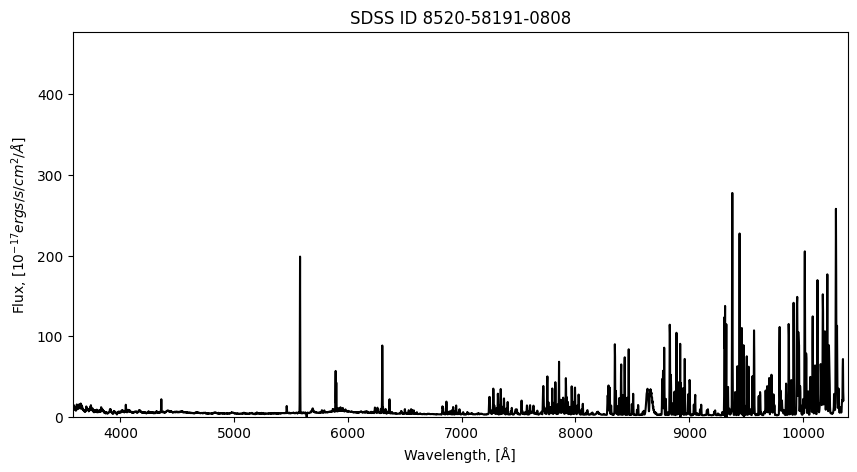

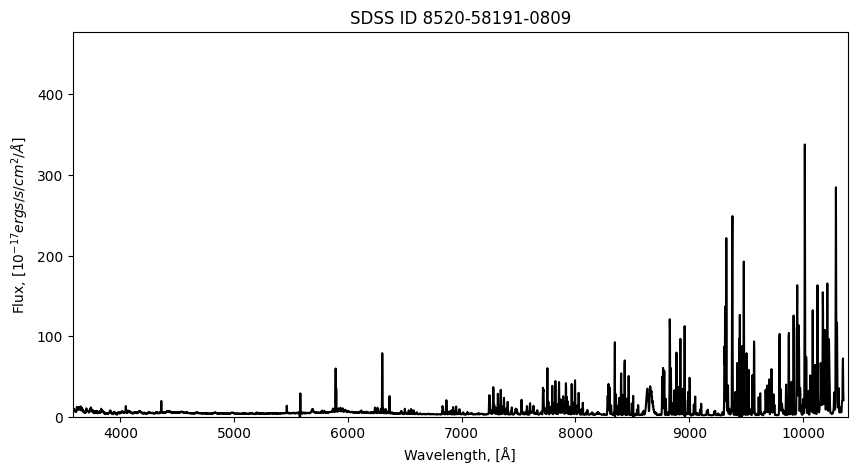

In [ ]:
# @title Plot every sky spectra
# for seeing how they differ between measurements, I guess

sky_spectra = [spectrum[1].data['sky'] for spectrum in spectra_fits]
sky_wavelengths = [10**spectrum[1].data['loglam'] for spectrum in spectra_fits]

ss = len(sky_spectra)  # count of spectra


low_flux = min([min(flux) for flux in sky_spectra])
high_flux = max([max(flux) for flux in sky_spectra])

low_lam = min([min(lam) for lam in sky_wavelengths])
high_lam = max([max(lam) for lam in sky_wavelengths])


# make combined plot
plt.subplots(1, 1, figsize=(15, 7.5))

plt.plot([], color='r', linewidth=1, label="MJD = 53433")
for i in range(0, 9):
  plt.plot(sky_wavelengths[i], sky_spectra[i], color='r', linewidth=0.1, zorder=3)

plt.plot([], color='g', linewidth=1, label="MJD = 56067, 56072")
for i in range(9, 25):
  plt.plot(sky_wavelengths[i], sky_spectra[i], color='g', linewidth=0.1, zorder=2)

plt.plot([], color='b', linewidth=1, label="MJD = 58191")
for i in range(25, ss):
  plt.plot(sky_wavelengths[i], sky_spectra[i], color='b', linewidth=0.1, zorder=1)

plt.title(f"Overlapped SDSS sky spectra for selection")
plt.xlabel("Wavelength, [Å]")
plt.xlim(low_lam, high_lam)
plt.ylabel("Flux, [$10^{-17} ergs/s/cm^2/\AA$]")
plt.ylim(low_flux, high_flux)
plt.legend()
plt.show()


# plot each spectrum individually
for i in range(ss):
  plt.subplots(1, 1, figsize=(10, 5))
  plt.plot(sky_wavelengths[i], sky_spectra[i], color='k')
  plt.title(f"SDSS ID {spectra_files[i][5:-5]}")
  plt.xlabel("Wavelength, [Å]")
  plt.xlim(low_lam, high_lam)
  plt.ylabel("Flux, [$10^{-17} ergs/s/cm^2/\AA$]")
  plt.ylim(low_flux, high_flux)
  plt.show()

In [ ]:
# @title FITs file header information
# for me to get a better idea of how these files are structured

spectrum = spectra_fits[random.randint(0, 31)]  # HDUL
spectrum.info()

print()

HDU0 = spectrum[0]
HDU1 = spectrum[1]
HDU2 = spectrum[2]
HDU3 = spectrum[3]

print()

print("PRIMARY\n   ", list(HDU0.header), "\n")
print("COADD\n   ", list(HDU1.header), "\n")
print("SPALL\n   ", list(HDU2.header), "\n")
print("SPZLINE\n   ", list(HDU3.header), "\n")

Filename: spec-5164-56067-0588.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     122   ()      
  1  COADD         1 BinTableHDU     26   4621R x 8C   [E, E, E, J, J, E, E, E]   
  2  SPALL         1 BinTableHDU    488   1R x 236C   [27A, 14A, 4A, E, E, J, J, E, J, E, E, E, K, K, K, K, K, K, K, K, K, B, B, J, I, 5E, 5E, J, J, J, J, 7A, 7A, 16A, D, D, 6A, 21A, E, E, E, J, E, 24A, 10J, J, 10E, E, E, E, E, E, E, J, E, E, E, J, 5E, E, E, 10E, 10E, 10E, 5E, 5E, 5E, 5E, 5E, J, J, E, E, E, E, E, E, 16A, 9A, 12A, E, E, E, E, E, E, E, E, J, E, E, J, J, 6A, 21A, E, 35E, K, 19A, 19A, 19A, B, B, B, I, 3A, B, I, I, I, I, J, E, J, J, E, E, E, E, E, E, E, E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5J, 5J, 5J, 5E, 5J, 75E, 75E, 5E, 5E, 5E, 5J, 5E, D, D, D, D, D, D, D, D, D, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E